# Advanced neural data selection

Often times we want to subselect neural data that match certain meta data parameters. For example, to compare neurophysiology on vs. off deep brain stimulation, we would need to filter data by therapy status. We could also filter by stimulation frequency, stimulation amplitude, sensing sampling rate, etc. 

This template is an example of how to use Rune's API to find windows of time in which meta data parameters were met. We specify filtering parameters and target values, and we retrieve a list of time stamps for data epochs that match our critera. Note that these time stamps represent windows in which meta data parameters were constant, but do not necessarily represent times when data were streamed. For example, if sampling rate was constant at 250 hz for 2 weeks and the subject streamed data for 2 days within that period, these functions will return the full two week window. To find epochs in which all of our settings were met **and** data were streamed, we can check for overlap between the epochs returned here and the epochs found using the `availability` expression in the previous notebook.

In [25]:
import io
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from runeq import Config, stream
from collections import defaultdict

## Functions for API calls

These wrapper functions use Rune's API and Python package `runeq` to pull meta data about stimulation, sensing, and adaptive parameters. The outputs are state values for each parameter, in addition to time stamps for each state value. 

Additionally, the API can be used to pull raw neural time series data, spectrograms, and power spectra. A wrapper function for pulling neural time series is included for demonstration of how to retrieve data after we have identified time stamps for data of interest (this function is from the previous notebook `01_download_neural_data`).

In [26]:
def make_full_df(accessor):
    """Loop through pages of API calls and append to a single dataframe"""

    df = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        df = df.append(page_df, ignore_index=True)

    return df

def get_stimulation_meta_data(client, params):
    """Makes API calls for stimulation meta data, outputs dataframe"""
      
    stimulation_fields = {
        'event': 'therapy_status',
            'fields': 'active_group,'
                      'therapy_status'
    }    

    accessor = client.State(**stimulation_fields, **params)
    return make_full_df(accessor)


def get_sensing_meta_data(client, params):
    """Makes API calls for sensing meta data, outputs dataframe"""

    sensing_fields = {        
        'event': 'sampling_frequency.lfp',
        'fields': 'frequency_hz'
    }

    accessor = client.State(**sensing_fields, **params)
    return make_full_df(accessor)


def get_adaptive_meta_data(client, params):
    """Makes API calls for adaptive meta data, outputs dataframe"""

    adaptive_fields = {
        'event': 'adaptive_update',
        'fields': 'adaptive_state,'
                  'ld0_detection_status,'
                  'ld0_feature_0,'
                  'ld0_feature_1,'
                  'ld0_feature_2,'
                  'ld0_feature_3,'
                  'ld0_fixed_decimal_point,'
                  'ld0_output,'
                  'ld0_threshold_high,'
                  'ld0_threshold_low,'
                  'ld1_detection_status,'
                  'ld1_feature_0,'
                  'ld1_feature_1,'
                  'ld1_feature_2,'
                  'ld1_feature_3,'
                  'ld1_fixed_decimal_point,'
                  'ld1_output,'
                  'ld1_threshold_high,'
                  'ld1_threshold_low,'
                  'program_0_amplitude_amp,'
                  'program_1_amplitude_amp,'
                  'program_2_amplitude_amp,'
                  'program_3_amplitude_amp,'
                  'sensing_status,'
                  'sensing_status_adaptive_stim,'
                  'sensing_status_detection_ld_0,'
                  'sensing_status_detection_ld_1,'
                  'sensing_status_fft,'
                  'sensing_status_lfp_sensing,'
                  'sensing_status_loop_recording,'
                  'sensing_status_none,'
                  'sensing_status_power,'
                  'sensing_status_unused,'
                  'state_entry_count,'
                  'state_time,'
                  'stim_flag_program_0,'
                  'stim_flag_program_1,'
                  'stim_flag_program_2,'
                  'stim_flag_program_3,'
                  'stim_flags,'
                  'stim_rate_hz'
    }

    accessor = client.State(**adaptive_fields, **params)
    return make_full_df(accessor)


def get_neural_time_series(client, params, save_filepath=None):
    """
    Makes API calls for neural time series, saves to CSV and outputs
    dataframe
    """

    accessor = client.LFP(**params)
    df = make_full_df(accessor)
    if save_filepath:
        df.to_csv(save_filepath)
    return df

## Functions for finding data epochs

Rune's API returns timestamps for state values. These timestamps reflect times when information about these state values were available and/or changed. The following functions take those timestamps and generate time windows, or epochs, where data match individual or multiple criteria (these functions are from the previous notebook). However, they do not necessarily reflect when data were available.

In [27]:
def find_epochs(timestamp_series, state_series, state_match):
    """
    Returns start/stop time of data epochs based off state changes
    For example, we want to find all data epochs in which sampling rate == 250
    Each epoch starts when the first sampling rate event == 250
    Each epoch ends when sampling rate changes to different value

    Input:
        time_series - unix time stamps for each state <pd series>
        state_series - values for a particular state <pd series>
        state_match - desired state value <int, float, or string>
    Output:
        epochs - list of unix time stamps for epoch start/stop
    """

    # calculate changes in adjacent values to identify state changes
    match = pd.DataFrame([1 if x == state_match else 0 for x in state_series])
    match['change'] = match.diff()

    # when 'change' is 0, then a current value is same as previous value
    # an epoch begins when the change value is 1
    # an epoch ends when the change value is -1
    start_idx = [((np.isnan(x) and y == 1) or x == 1)
                 for x, y in zip(match['change'], match[0])]
    stop_idx = [x == -1 for x in match['change']]

    # obtain datetime stamps for the start and stop of all epochs
    window_start = timestamp_series[start_idx]
    window_stop = timestamp_series[stop_idx]

    # if the last epoch has no stop, add the last datetime stamp as the stop
    if len(window_start) > len(window_stop):
        window_stop = window_stop.append(
            pd.Series(timestamp_series.iloc[-1]), ignore_index=True)

    # make array of start/stop times
    epochs = np.array([window_start.values, window_stop.values]).transpose()

    return epochs


def find_overlapping_epochs(*conditions):
    """
    Return epochs where all conditions are true.

    Input:
        One or more conditions. Each condition is a list of epochs.
        Each epoch is a list/tuple with 2 elements: the start and
        end time of a time interval where the condition was true.

    Output:
        A list of tuples, where each tuple represents the start and
        end time of an epoch where all the conditions are true
    """

    # compile a set of all the timestamps
    times = set()

    # create a dictionary that summarizes the overall change at
    # each timestamp: the net number of conditions that become true
    change_at_time = defaultdict(int)

    for condition in conditions:
        for epoch in condition:
            start, end = epoch
            times.add(start)
            times.add(end)
            # When a condition starts, the change at time t is positive
            change_at_time[start] += 1
            # When a condition ends, the change at time t is negative
            change_at_time[end] -= 1

    results = []

    # now go through the timestamps *in order*, and keep track of
    # the cumulative sum of change_at_time:
    num_on = 0

    num_conditions = len(conditions)

    # when we find a timestamp where all of the conditions are true
    # (i.e. cumulative sum = num_conditions), keep track of the
    # start time:
    current_epoch_start = None

    for time in sorted(times):
        num_on += change_at_time[time]
        if num_on == num_conditions and current_epoch_start is None:
            current_epoch_start = time

        if num_on != num_conditions and current_epoch_start is not None:
            results.append((current_epoch_start, time))
            current_epoch_start = None

    if not results:
        print('No epochs matching all criteria')

    return results


def filter_by_epoch_duration(epochs, min_duration):
    """
    Given a list of epoch start/end times, returns epoch start/end times
    that are at least minimum duration (sec)
    """

    epoch_durations = [epoch[1]-epoch[0] for epoch in epochs]
    keep_idx = [epoch_duration >=
                min_duration for epoch_duration in epoch_durations]

    return np.array(epochs_overlap_all)[np.array(keep_idx)].tolist()

## Function for plotting data 

This function is for visualizing data availability that meet filtering criteria.

Note: In this notebook, plots are static. Use magic function `%matplotlib notebook` for interactive zooming and panning.

In [28]:
def plot_epochs(condition_names, *conditions):
    """
    Plots data availability for one or more conditions

    Input: List of condition names, list of start/end times for epochs per
    condition
    """

    num_conditions = len(conditions)

    fig, ax = plt.subplots(figsize=(12, 5))

    for idx, condition in enumerate(conditions):
        for epoch in condition:
            ax.plot(
                [datetime.datetime.fromtimestamp(epoch[0]),
                 datetime.datetime.fromtimestamp(epoch[1])],
                [idx, idx],
                linewidth=25
            )

    plt.xticks(rotation=90)
    plt.yticks(np.arange(num_conditions), condition_names)
    plt.tight_layout()
    plt.xlabel('Time')
    plt.ylabel('Filter Criteria')
    plt.title('Data Availability')

## Data selection in a single subject

First we will use the API to pull all meta data. We will specify which parameters we want to filter by, and then we will identify epochs in which all filtering criteria were met. We can customize which meta data parameters and how many we use.

## 1. Initialize API credentials

In [29]:
# set up client

cfg = Config()
client = stream.V1Client(cfg)

In [30]:
# initialize parameters for API calls

params = {
    'patient_id': 'rcs07',
    'device_id': 'NPC700403H',
    'start_time': datetime.datetime(2019, 9, 1).timestamp(),
    'end_time': datetime.datetime(2020, 4, 30).timestamp(),
    'algorithm': 'medtronic-rcs-3'
}

Here we specified a particular date range, but if you want to pull **all** meta data, you can set `start_time` to 0 and `end_time` to today:
```
start_time = 0
end_time = datetime.datetime.now().timestamp()
```

## 2. Pull meta data for stimulation and sensing parameters

In [31]:
# get stimulation, sensing, and adaptive meta data

stimulation_meta_data = get_stimulation_meta_data(client, params)
sensing_meta_data = get_sensing_meta_data(client, params)
adaptive_meta_data = get_adaptive_meta_data(client, params)

In [32]:
stimulation_meta_data.head(5)

,time,active_group,therapy_status
0,1.567289e+09,NaN,NaN
1,1.568138e+09,0.0,0.0
2,1.568233e+09,0.0,0.0
3,1.568233e+09,0.0,0.0
4,1.568233e+09,0.0,0.0


In [33]:
sensing_meta_data.head(5)

,time,frequency_hz
0,1.567289e+09,NaN
1,1.568233e+09,500.0
2,1.568233e+09,1000.0
3,1.568823e+09,500.0
4,1.568823e+09,1000.0


In [34]:
adaptive_meta_data.head(5)

,time,adaptive_state,ld0_detection_status,ld0_feature_0,ld0_feature_1,ld0_feature_2,ld0_feature_3,ld0_fixed_decimal_point,ld0_output,ld0_threshold_high,...,sensing_status_power,sensing_status_unused,state_entry_count,state_time,stim_flag_program_0,stim_flag_program_1,stim_flag_program_2,stim_flag_program_3,stim_flags,stim_rate_hz
0,1.567289e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.583862e+09,0.0,0.0,1524.0,0.0,0.0,0.0,0.0,1524.0,55001.0,...,1.0,0.0,8074.0,15378194.0,0.0,0.0,0.0,0.0,0.0,130.2
2,1.583862e+09,0.0,0.0,4749.0,0.0,0.0,0.0,0.0,4749.0,55001.0,...,1.0,0.0,8074.0,15378195.0,0.0,0.0,0.0,0.0,0.0,130.2
3,1.583862e+09,0.0,0.0,9359.0,0.0,0.0,0.0,0.0,9359.0,55001.0,...,1.0,0.0,8074.0,15378196.0,0.0,0.0,0.0,0.0,0.0,130.2
4,1.583862e+09,0.0,0.0,4329.0,0.0,0.0,0.0,0.0,4329.0,55001.0,...,1.0,0.0,8074.0,15378197.0,0.0,0.0,0.0,0.0,0.0,130.2


There are various sensing and stimulation related parameters that we can filter by. A full list of parameters are below: 

In [35]:
print('Stimulation Parameters: ')
print(*list(stimulation_meta_data.columns[1:]), sep="\n")
print('\nSensing Parameters: ')
print(*list(sensing_meta_data.columns[1:]), sep="\n")
print('\nAdaptive Parameters: ')
print(*list(adaptive_meta_data.columns[1:]), sep="\n")

Stimulation Parameters: 
active_group
therapy_status

Sensing Parameters: 
frequency_hz

Adaptive Parameters: 
adaptive_state
ld0_detection_status
ld0_feature_0
ld0_feature_1
ld0_feature_2
ld0_feature_3
ld0_fixed_decimal_point
ld0_output
ld0_threshold_high
ld0_threshold_low
ld1_detection_status
ld1_feature_0
ld1_feature_1
ld1_feature_2
ld1_feature_3
ld1_fixed_decimal_point
ld1_output
ld1_threshold_high
ld1_threshold_low
program_0_amplitude_amp
program_1_amplitude_amp
program_2_amplitude_amp
program_3_amplitude_amp
sensing_status
sensing_status_adaptive_stim
sensing_status_detection_ld_0
sensing_status_detection_ld_1
sensing_status_fft
sensing_status_lfp_sensing
sensing_status_loop_recording
sensing_status_none
sensing_status_power
sensing_status_unused
state_entry_count
state_time
stim_flag_program_0
stim_flag_program_1
stim_flag_program_2
stim_flag_program_3
stim_flags
stim_rate_hz


We can filter by any combination of parameters. Before specifying particular values for each parameter, we can check what potential values are:

In [36]:
print('Unique values for sampling frequency: ')
print(sensing_meta_data.frequency_hz.unique())

Unique values for sampling frequency: 
[  nan  500. 1000.  250.]


## 3. Identify epochs that match meta data parameters

### Example 1

We will start off with an example filter using 2 parameters:
- Therapy status (off stimulation)
- Sampling frequency (250 hz)

In [37]:
# meta data filter settings

target_therapy_status = 0
target_sampling_frequency = 250

In [38]:
# get list of epochs matching each condition/criteria

epochs_therapy_status = find_epochs(
    stimulation_meta_data.time,
    stimulation_meta_data.therapy_status,
    target_therapy_status
)
epochs_sampling_frequency = find_epochs(
    sensing_meta_data.time,
    sensing_meta_data.frequency_hz,
    target_sampling_frequency
)

In [39]:
# find overlap across all epochs

epochs_overlap_all = find_overlapping_epochs(
    epochs_therapy_status,
    epochs_sampling_frequency
)

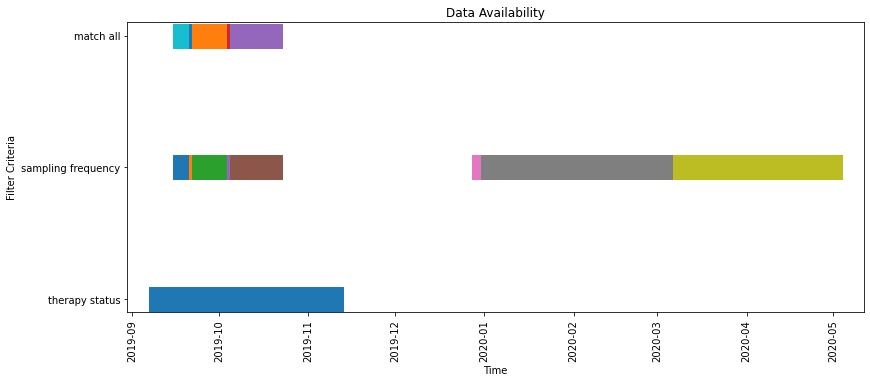

In [40]:
# plot data availability

plot_epochs(
    [
        'therapy status',
        'sampling frequency',
        'match all'
    ],
    epochs_therapy_status,
    epochs_sampling_frequency,
    epochs_overlap_all
)

For each individual filtering parameter, shaded bars correspond to epochs when data exist and meet that criterion. The 'match all' row identifies epochs that meet all critera.

Note that time stamps are in UTC time, and will need to be adjusted for your particular time zone. Pacific time adjustment is -8 hours (-28800 seconds).

### Example 2

In this last example, we will filter by adaptive stimulation parameters as well.

- Therapy status (on stimulation)
- Sampling frequency (250 hz)
- Adaptive sensing status (151, Medtronic code)
- Adaptive ld 0 detection status (15, Medtronic code)
- Minimum duration (10 min)

Certain parameters, including adaptive settings, are currently still the raw values from the json files. They will need to be 'translated' for meaning.

In [41]:
print('Unique values for sensing status: ')
print(adaptive_meta_data.sensing_status.unique())

Unique values for sensing status: 
[ nan  23. 151.]


In [42]:
print('Unique values for ld0 detection status: ')
print(adaptive_meta_data['ld0_detection_status'].unique())

Unique values for ld0 detection status: 
[nan  0. 47. 15. 64. 32. 37.  5.]


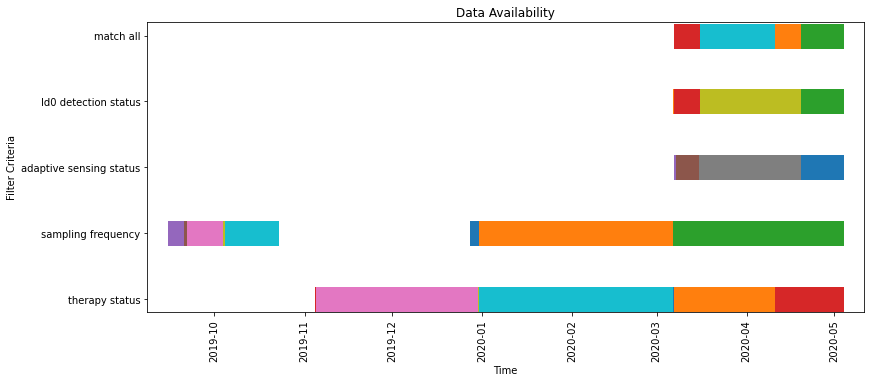

In [43]:
# meta data filter settings
target_therapy_status = 1
target_sampling_frequency = 250
target_adaptive_sensing_status = 151
target_ld0_detection_status = 15
min_epoch_duration = 10*60

# find epochs for each individual condition
epochs_therapy_status = find_epochs(
    stimulation_meta_data.time,
    stimulation_meta_data.therapy_status,
    target_therapy_status
)
epochs_sampling_frequency = find_epochs(
    sensing_meta_data.time,
    sensing_meta_data.frequency_hz,
    target_sampling_frequency
)
epochs_adaptive_sensing_status = find_epochs(
    adaptive_meta_data.time,
    adaptive_meta_data.sensing_status,
    target_adaptive_sensing_status
)
epochs_ld0_detection_status = find_epochs(
    adaptive_meta_data.time,
    adaptive_meta_data['ld0_detection_status'],
    target_ld0_detection_status
)

# find overlap across all epochs
epochs_overlap_all = find_overlapping_epochs(
    epochs_therapy_status,
    epochs_sampling_frequency,
    epochs_adaptive_sensing_status,
    epochs_ld0_detection_status
)

# only keep epochs that are greater than or equal to the minimum duration
if epochs_overlap_all:
    epochs_overlap_all = filter_by_epoch_duration(
        epochs_overlap_all, min_epoch_duration)

# plot data availability
plot_epochs(
    [
        'therapy status',
        'sampling frequency',
        'adaptive sensing status',
        'ld0 detection status',
        'match all'
    ],
    epochs_therapy_status,
    epochs_sampling_frequency,
    epochs_adaptive_sensing_status,
    epochs_ld0_detection_status,
    epochs_overlap_all
)

## 4. Use epoch time stamps to retrieve data

After selecting and specifying filtering criteria, the function `find_overlapping_epochs` returns  `epochs_overlap_all`, a list of time stamps that indicate epoch start and end times for every epoch that matches all filtering criteria. We can use these time stamps to obtain raw time series.

In [44]:
# print duration of each epoch

for idx, epoch in enumerate(epochs_overlap_all):
    start = datetime.datetime.fromtimestamp(epoch[0])
    stop = datetime.datetime.fromtimestamp(epoch[1])
    print('Epoch', str(idx), ':', stop-start)

Epoch 0 : 17:56:23.008000
Epoch 1 : 2:35:30.304000
Epoch 2 : 0:18:00.014000
Epoch 3 : 0:28:30.089000
Epoch 4 : 0:20:00.004000
Epoch 5 : 0:11:51.857000
Epoch 6 : 25 days, 18:55:20.163000
Epoch 7 : 2:46:23.946000
Epoch 8 : 8 days, 20:20:19.476000
Epoch 9 : 6 days, 0:59:26.758000


We can loop through the epochs, download the raw data, and save to CSV files. For demonstration, we will download the raw time series for epoch 2. 

In [45]:
# retrieve raw data for one epoch

FILE_PATH = '~/Documents/api_data/nb01_ex01_neural_time_series.csv'

EPOCH_NUM = 2

params = {
    'patient_id': 'rcs07',
    'device_id': 'NPC700403H',
    'start_time': epochs_overlap_all[EPOCH_NUM][0],
    'end_time': epochs_overlap_all[EPOCH_NUM][1],
    'channels': '0,1,2,3'
}

neural_time_series = get_neural_time_series(client, params, FILE_PATH)

In [46]:
# change timestamps to datetime for plotting

neural_time_series.timestamp = pd.to_datetime(
    neural_time_series.timestamp, unit='s')
neural_time_series

,timestamp,channel.0,channel.1,channel.2,channel.3
0,2020-03-11 20:02:24.880000000,-0.000149,-0.000131,-0.000235,-0.000150
1,2020-03-11 20:02:24.884000000,-0.000158,-0.000140,-0.000238,-0.000155
2,2020-03-11 20:02:24.888000000,-0.000148,-0.000132,-0.000228,-0.000155
3,2020-03-11 20:02:24.892000000,-0.000158,-0.000143,-0.000207,-0.000155
4,2020-03-11 20:02:24.896000000,-0.000147,-0.000132,-0.000180,-0.000148
...,...,...,...,...,...
269829,2020-03-11 20:20:24.874000128,-0.000148,-0.000133,-0.000241,-0.000160
269830,2020-03-11 20:20:24.878000128,-0.000153,-0.000139,-0.000227,-0.000156
269831,2020-03-11 20:20:24.881999872,-0.000151,-0.000135,-0.000231,-0.000162
269832,2020-03-11 20:20:24.885999872,-0.000153,-0.000138,-0.000226,-0.000167


Text(0, 0.5, 'Voltage (V)')

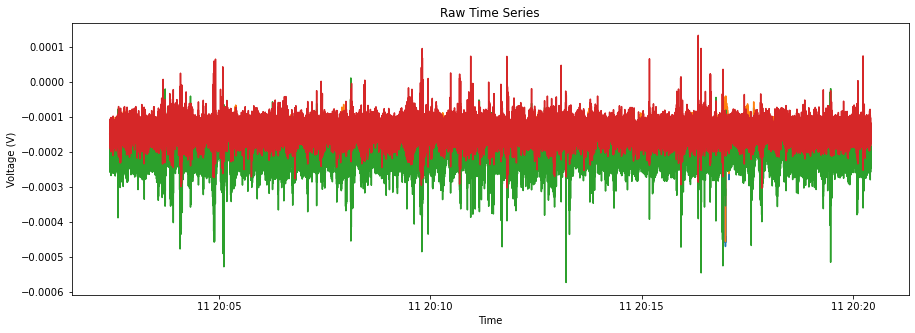

In [47]:
# plot epoch across all four channels

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(neural_time_series.timestamp, neural_time_series['channel.0'])
ax.plot(neural_time_series.timestamp, neural_time_series['channel.1'])
ax.plot(neural_time_series.timestamp, neural_time_series['channel.2'])
ax.plot(neural_time_series.timestamp, neural_time_series['channel.3'])
plt.title('Raw Time Series')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')

## Summary

We pulled information about sensing, stimulation, and adaptive parameters for a single subject. We used these parameters to further filter the data and identify epochs in which all our criteria were met. The user can specify which combination of parameters to filter by. We then demonstrated how to use these time stamps to pull raw time series data to save as a CSV.